## Calculate the Screen Time of Actors in any Video(with Python codes)

1. Import and read the video, extract frames from it, and save them as images
2. Label a few images for training the model(学習済みmodelがある)
3. Build our model on training data
4. Make predictions for the remaining images
5. Calculate the screen time of both TOM and JERRY

### How to handle video files in Python

In [2]:
import cv2 # for capturing videos
import math 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from keras.preprocessing import image # for preprocessing the images
import numpy as np
from keras.utils import np_utils
from skimage.transform import resize

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


using GPU: 0 (thre:0.5)


#### [Step-1]Read the video, extract frames from it and save them as images

In [5]:
count = 0
videoFile = "Tom and jerry.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate = 30.408...(1frame/sec)
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0): # math.floor(frameRate)=30
        filename ="frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


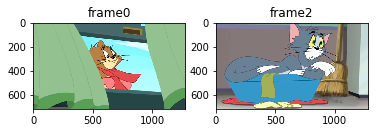

In [9]:
plt.subplot(1,2,1)
plt.title('frame0')
img = plt.imread('frame0.jpg')   # reading image using its name
plt.imshow(img)

plt.subplot(1,2,2)
plt.title('frame2')
img = plt.imread('frame2.jpg')
plt.imshow(img)

ImageNetのpre-trained modelでは一般画像しか扱ってないので，TomとJerryを識別することは困難？

#### [Step-2]Label a few images for training the model

- 0：neither Jerry nor Tom
- 1：for Jerry
- 2：for Tom

In [7]:
data = pd.read_csv('mapping.csv')
data.head() # printing first five rows of the file

,Image_ID,Class
0,frame0.jpg,1
1,frame1.jpg,1
2,frame2.jpg,2
3,frame3.jpg,2
4,frame4.jpg,2


- Image_ID：Contains the name of each image
- Class. Image_ID：Contains corresponding class for each image

In [10]:
X = [ ]     # creating an empty array
for img_name in data.Image_ID:
    img = plt.imread('' + img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

In [11]:
y = data.Class
dummy_y = np_utils.to_categorical(y)    # one hot encoding Classes

VGG16のpre-trained modelを使うので，画像を(224×224×3)にリサイズする．

In [12]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

/usr/local/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


VGG16のpre-trained modelに入力する前に，モデルの要求する前処理をする必要がある．

In [13]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X, mode='tf')      # preprocessing the input data

training setとvalidation setの作成．

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)    # preparing the validation set

#### [Step-3]Building the model

In [15]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

In [16]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))    # include_top=False to remove the top layer

Instructions for updating:
Colocations handled automatically by placer.


X_trainとX_validに対してモデル予測を行い，特徴を得て再学習する．

In [17]:
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)
X_train.shape, X_valid.shape # X_train：(7×7×512)×208, X_valid：(7×7×512)×90

((208, 7, 7, 512), (90, 7, 7, 512))

Neural Networkに渡すために，1-Dに変換する．

In [18]:
X_train = X_train.reshape(208, 7*7*512)      # converting to 1-D
X_valid = X_valid.reshape(90, 7*7*512)

前処理とzero-centeringをすると，モデルの収束が早くなる．

In [19]:
train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

1.Building the model

In [20]:
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(3, activation='softmax'))    # output layer

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 25,694,211
Trainable params: 25,694,211
Non-trainable params: 0
_________________________________________________________________


2.Compiling the model

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

3.Training the model

In [23]:
model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 208 samples, validate on 90 samples
Epoch 1/100
208/208 [==============================] - 1s 4ms/step - loss: 1.1795 - acc: 0.5288 - val_loss: 0.6941 - val_acc: 0.7667
Epoch 2/100
208/208 [==============================] - 0s 501us/step - loss: 0.4867 - acc: 0.7740 - val_loss: 0.5605 - val_acc: 0.7889
Epoch 3/100
208/208 [==============================] - 0s 495us/step - loss: 0.2814 - acc: 0.9087 - val_loss: 0.4681 - val_acc: 0.8222
Epoch 4/100
208/208 [==============================] - 0s 498us/step - loss: 0.1529 - acc: 0.9567 - val_loss: 0.3734 - val_acc: 0.8667
Epoch 5/100
208/208 [==============================] - 0s 497us/step - loss: 0.0832 - acc: 0.9760 - val_loss: 0.3952 - val_acc: 0.8333
Epoch 6/100
208/208 [==============================] - 0s 496us/step - loss: 0.0570 - acc: 0.9808 - val_loss: 0.3225 - val_acc: 0.8667
Epoch 7/100
208/208 [==============================] - 0s 498us/step - loss: 0.0422 - acc: 0.9904 -

学習データ上で85.56%の認識精度を達成していることがわかる．

#### Calculating the screen time - A simple solution

In [24]:
count = 0
videoFile = "Tom and Jerry 3.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


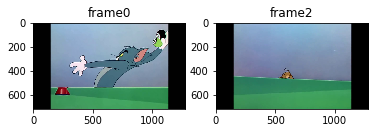

In [32]:
plt.subplot(1,2,1)
plt.title('frame0')
img = plt.imread('test0.jpg')   # reading image using its name
plt.imshow(img)

plt.subplot(1,2,2)
plt.title('frame2')
img = plt.imread('test2.jpg')
plt.imshow(img)

In [31]:
test = pd.read_csv('test.csv')
test.head()

,Image_ID
0,test0.jpg
1,test1.jpg
2,test2.jpg
3,test3.jpg
4,test4.jpg


In [26]:
test_image = []
for img_name in test.Image_ID:
    img = plt.imread('' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [27]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

/usr/local/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [28]:
# preprocessing the images
test_image = preprocess_input(test_image, mode='tf')

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)

# converting the images to 1-D form
test_image = test_image.reshape(186, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

#### [Step-4]Make predictions for the remaining images

In [29]:
predictions = model.predict_classes(test_image)

In [30]:
predictions

array([2, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 0, 2, 2, 2])

#### [Step-5]Calculate the screen time of both TOM & JERRY

In [27]:
print("The screen time of JERRY is", predictions[predictions==1].shape[0], "seconds")
print("The screen time of TOM is", predictions[predictions==2].shape[0], "seconds")

The screen time of JERRY is 6 seconds
The screen time of TOM is 134 seconds
